In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from scipy.sparse import hstack,vstack,csc_matrix
from scipy import sparse
import re
from matplotlib.backends.backend_pdf import PdfPages
#import leidenalg
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from scipy.stats import chi2_contingency

In [2]:
save_path="D:\CCLE\pic"

In [3]:
#file reading
#Gene expression
CCLE_TPM = pd.read_csv("CCLE_expression.csv")
CCLE_TPM.index=CCLE_TPM['Unnamed: 0']
CCLE_TPM=CCLE_TPM.drop(columns='Unnamed: 0') 
CCLE_TPM.columns=[re.search(r"\S+",i).group() for i in CCLE_TPM.columns]

#data phenotype
CCLE_pheno = pd.read_csv("sample_info.csv")
CCLE_pheno.index=CCLE_pheno['DepMap_ID']
#Metmap
CCLE_metmap500MP=pd.read_csv("MetMap_500__Metastatic_Potential.csv") 
CCLE_metmap500MP.index=CCLE_metmap500MP['Unnamed: 0']
CCLE_metmap500MP=CCLE_metmap500MP.drop(columns='Unnamed: 0') 



In [4]:
CCLE_pheno_lung=CCLE_pheno.loc[(CCLE_pheno['primary_disease']=='Lung Cancer') ,:]
CCLE_metmap500MP_lung=CCLE_metmap500MP.loc[list(set(CCLE_pheno_lung.index).intersection(set(CCLE_metmap500MP.index))),:]
CCLE_metmap500MP_lung['CCLE_name']=list(CCLE_metmap500MP_lung.index)
CCLE_metmap500MP_lung['Celllinename']=list(CCLE_pheno.loc[CCLE_metmap500MP_lung.index,'cell_line_name'])

for i in CCLE_metmap500MP_lung.columns[0:6]:
    CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung[i]< -2, i+'_color']='Non-metastatic'
    CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung[i]> -2 ,i+'_color']='Metastatic'
CCLE_metmap500MP_lung = CCLE_metmap500MP_lung.sort_values(by=['all5'],ascending=False )

In [5]:
CCLE_metmap500MP_lung=CCLE_metmap500MP_lung.rename(columns={"all5_color":"metastatic_type"})

In [6]:
df1=CCLE_metmap500MP_lung[["Celllinename","metastatic_type"]]
df1

,Celllinename,metastatic_type
Unnamed: 0,,
ACH-000463,NCI-H460,Metastatic
ACH-000749,DMS 273,Metastatic
ACH-000444,LU99,Metastatic
ACH-000813,T3M-10,Metastatic
ACH-000945,NCI-H650,Metastatic
...,...,...
ACH-000390,LUDLU-1,Non-metastatic
ACH-000416,NCI-H838,Non-metastatic
ACH-000800,NCI-H446,Non-metastatic


In [7]:
df2=CCLE_pheno_lung[["cell_line_name","sex","primary_or_metastasis","age","Subtype"]]
df2

,cell_line_name,sex,primary_or_metastasis,age,Subtype
DepMap_ID,,,,,
ACH-000033,NCI-H1819,Female,Metastasis,55,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci..."
ACH-000179,NCI-H1618,Female,Metastasis,55,Small Cell Lung Cancer (SCLC)
ACH-000297,NCI-H889,Female,Metastasis,69,Small Cell Lung Cancer (SCLC)
ACH-000523,NCI-H1184,Male,Metastasis,42,Small Cell Lung Cancer (SCLC)
ACH-000553,Sq-1,Male,Primary,NaN,"Non-Small Cell Lung Cancer (NSCLC), Squamous C..."
...,...,...,...,...,...
ACH-002193,RERF-LC-FM,Male,Metastasis,NaN,Small Cell Lung Cancer (SCLC)
ACH-002196,SBC-1,Male,NaN,46,Small Cell Lung Cancer (SCLC)
ACH-002197,SBC-3,Male,Metastasis,24,Small Cell Lung Cancer (SCLC)


In [8]:
df3=pd.merge(df2,df1,left_on="cell_line_name",right_on="Celllinename",how="inner")
df3

,cell_line_name,sex,primary_or_metastasis,age,Subtype,Celllinename,metastatic_type
0,Sq-1,Male,Primary,NaN,"Non-Small Cell Lung Cancer (NSCLC), Squamous C...",Sq-1,Non-metastatic
1,T3M-10,Male,Metastasis,40,"Non-Small Cell Lung Cancer (NSCLC), Large Cell...",T3M-10,Metastatic
2,NCI-H322,Male,Primary,52,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NCI-H322,Metastatic
3,NCI-H1373,Male,Primary,56,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NCI-H1373,Metastatic
4,HCC-1588,Female,Primary,63,"Non-Small Cell Lung Cancer (NSCLC), Squamous C...",HCC-1588,Non-metastatic
...,...,...,...,...,...,...,...
99,DV-90,Male,Metastasis,50,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",DV-90,Non-metastatic
100,NCI-H2110,NaN,Metastasis,NaN,"Non-Small Cell Lung Cancer (NSCLC), unspecified",NCI-H2110,Metastatic
101,NCI-H650,Male,Metastasis,NaN,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NCI-H650,Metastatic
102,NCI-H292,Female,Metastasis,32,"Non-Small Cell Lung Cancer (NSCLC), Mucoepider...",NCI-H292,Metastatic


C:\Users\61416\AppData\Local\Temp\ipykernel_31324\1328690229.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_path+"//"+"tmpa.pdf",dpi=400,facecolor='white',overwrite=True)


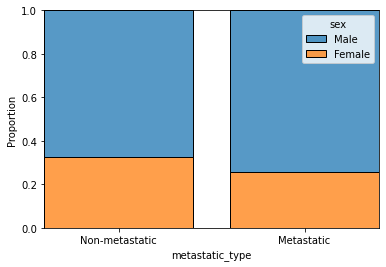

In [9]:
#the relationship between sex and metastatic_type
p1=sns.histplot(df3,stat="proportion",x="metastatic_type", hue="sex",color="sex",multiple="fill",shrink=.8)
plt.savefig(save_path+"//"+"tmpa.pdf",dpi=400,facecolor='white',overwrite=True)


In [62]:
df3_Non_metastatic=df3[df3["metastatic_type"]=="Non-metastatic"]
df3_Non_metastatic["sex"].value_counts()


Male      33
Female    16
Name: sex, dtype: int64

In [63]:
df3_Mmetastatic=df3[df3["metastatic_type"]=="Metastatic"]
df3_Mmetastatic["sex"].value_counts()


Male      40
Female    14
Name: sex, dtype: int64

In [64]:
#F-test between sex and metastatic_type
sex_metastatic_data=np.array([[33,16],[40,14]])
kf1=chi2_contingency(sex_metastatic_data)
print("chisp-statistic=%.4f,p-value=%.4f,df=%i expected_frep=%s"%kf1)

chisp-statistic=0.2844,p-value=0.5938,df=1 expected_frep=[[34.72815534 14.27184466]
 [38.27184466 15.72815534]]


C:\Users\61416\AppData\Local\Temp\ipykernel_31324\2077930650.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_path+"//"+"tmpb.pdf",dpi=400,facecolor='white',overwrite=True)


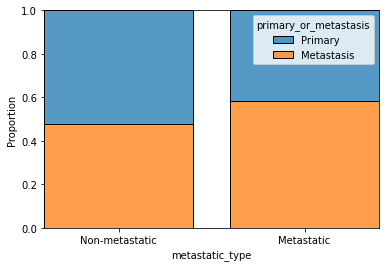

In [10]:
#the relationship between primary_or_metastasis and metastatic_type
p2=sns.histplot(df3,stat="proportion", x="metastatic_type", hue="primary_or_metastasis",color="primary_or_metastasis",multiple="fill",shrink=.8)
plt.savefig(save_path+"//"+"tmpb.pdf",dpi=400,facecolor='white',overwrite=True)


In [65]:
df3_Non_metastatic["primary_or_metastasis"].value_counts()

Primary       24
Metastasis    22
Name: primary_or_metastasis, dtype: int64

In [66]:
df3_Mmetastatic["primary_or_metastasis"].value_counts()

Metastasis    32
Primary       23
Name: primary_or_metastasis, dtype: int64

In [67]:
#F-test between primary_or_metastasis and metastatic_type
primary_or_metastasis_metastatic_data=np.array([[24,22],[32,23]])
kf2=chi2_contingency(primary_or_metastasis_metastatic_data)
print("chisp-statistic=%.4f,p-value=%.4f,df=%i expected_frep=%s"%kf2)

chisp-statistic=0.1632,p-value=0.6862,df=1 expected_frep=[[25.5049505 20.4950495]
 [30.4950495 24.5049505]]


In [11]:
df3["Subtype"].value_counts()

Non-Small Cell Lung Cancer (NSCLC), Adenocarcinoma              47
Non-Small Cell Lung Cancer (NSCLC), Squamous Cell Carcinoma     19
Non-Small Cell Lung Cancer (NSCLC), Large Cell Carcinoma        12
Mesothelioma                                                     8
Small Cell Lung Cancer (SCLC)                                    7
Non-Small Cell Lung Cancer (NSCLC), unspecified                  6
Non-Small Cell Lung Cancer (NSCLC), Adenosquamous Carcinoma      3
Carcinoid                                                        1
Non-Small Cell Lung Cancer (NSCLC), Mucoepidermoid Carcinoma     1
Name: Subtype, dtype: int64

In [12]:
data2=df3[df3["Subtype"].isin(["Non-Small Cell Lung Cancer (NSCLC), Squamous Cell Carcinoma",
 "Non-Small Cell Lung Cancer (NSCLC), Large Cell Carcinoma",
 "Non-Small Cell Lung Cancer (NSCLC), Adenocarcinoma",
 "Mesothelioma","Small Cell Lung Cancer (SCLC)"])]
data2

,cell_line_name,sex,primary_or_metastasis,age,Subtype,Celllinename,metastatic_type
0,Sq-1,Male,Primary,NaN,"Non-Small Cell Lung Cancer (NSCLC), Squamous C...",Sq-1,Non-metastatic
1,T3M-10,Male,Metastasis,40,"Non-Small Cell Lung Cancer (NSCLC), Large Cell...",T3M-10,Metastatic
2,NCI-H322,Male,Primary,52,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NCI-H322,Metastatic
3,NCI-H1373,Male,Primary,56,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NCI-H1373,Metastatic
4,HCC-1588,Female,Primary,63,"Non-Small Cell Lung Cancer (NSCLC), Squamous C...",HCC-1588,Non-metastatic
...,...,...,...,...,...,...,...
96,HCC-1359,Female,Primary,55,"Non-Small Cell Lung Cancer (NSCLC), Large Cell...",HCC-1359,Non-metastatic
97,NCI-H1573,Female,Metastasis,35,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NCI-H1573,Metastatic
99,DV-90,Male,Metastasis,50,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",DV-90,Non-metastatic
101,NCI-H650,Male,Metastasis,NaN,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NCI-H650,Metastatic


In [34]:
data2[data2["Subtype"]=="Mesothelioma"]

,cell_line_name,sex,primary_or_metastasis,age,Subtype,Celllinename,metastatic_type
12,ACC-MESO-1,Female,NaN,61,Mesothelioma,ACC-MESO-1,Non-metastatic
13,NCI-H2452,Male,Metastasis,Adult,Mesothelioma,NCI-H2452,Non-metastatic
14,NCI-H2052,Male,Metastasis,65,Mesothelioma,NCI-H2052,Non-metastatic
23,MPP 89,Male,NaN,67,Mesothelioma,MPP 89,Non-metastatic
24,IST-MES2,Male,NaN,71,Mesothelioma,IST-MES2,Non-metastatic
25,MSTO-211H,Male,Metastasis,62,Mesothelioma,MSTO-211H,Non-metastatic
46,IST-MES1,Female,Primary,70,Mesothelioma,IST-MES1,Non-metastatic
52,NCI-H28,Male,Metastasis,48,Mesothelioma,NCI-H28,Non-metastatic


C:\Users\61416\AppData\Local\Temp\ipykernel_31324\890082085.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_path+"//"+"tmpc.pdf",dpi=400,facecolor='white',bbox_inches="tight",overwrite=True)


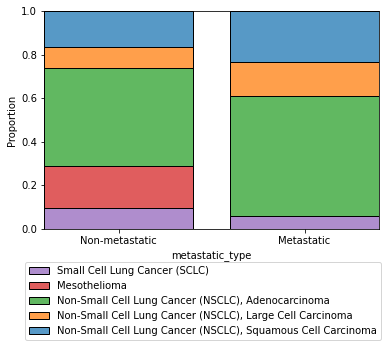

In [39]:
#the relationship between Subtype and metastatic_type
fig=sns.histplot(data2,stat="proportion", x="metastatic_type", hue="Subtype",color="Subtype",legend=False,multiple="fill",shrink=.8)
plt.legend(labels = ['Small Cell Lung Cancer (SCLC)',
 'Mesothelioma',
 'Non-Small Cell Lung Cancer (NSCLC), Adenocarcinoma',
 'Non-Small Cell Lung Cancer (NSCLC), Large Cell Carcinoma',
 'Non-Small Cell Lung Cancer (NSCLC), Squamous Cell Carcinoma'],loc = 'upper right',bbox_to_anchor=(1.02,-0.13))
plt.savefig(save_path+"//"+"tmpc.pdf",dpi=400,facecolor='white',bbox_inches="tight",overwrite=True)

In [14]:
data1=df3.drop(index=(df3.loc[(df3['age']=='Adult')].index))
data1

,cell_line_name,sex,primary_or_metastasis,age,Subtype,Celllinename,metastatic_type
0,Sq-1,Male,Primary,NaN,"Non-Small Cell Lung Cancer (NSCLC), Squamous C...",Sq-1,Non-metastatic
1,T3M-10,Male,Metastasis,40,"Non-Small Cell Lung Cancer (NSCLC), Large Cell...",T3M-10,Metastatic
2,NCI-H322,Male,Primary,52,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NCI-H322,Metastatic
3,NCI-H1373,Male,Primary,56,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NCI-H1373,Metastatic
4,HCC-1588,Female,Primary,63,"Non-Small Cell Lung Cancer (NSCLC), Squamous C...",HCC-1588,Non-metastatic
...,...,...,...,...,...,...,...
99,DV-90,Male,Metastasis,50,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",DV-90,Non-metastatic
100,NCI-H2110,NaN,Metastasis,NaN,"Non-Small Cell Lung Cancer (NSCLC), unspecified",NCI-H2110,Metastatic
101,NCI-H650,Male,Metastasis,NaN,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NCI-H650,Metastatic
102,NCI-H292,Female,Metastasis,32,"Non-Small Cell Lung Cancer (NSCLC), Mucoepider...",NCI-H292,Metastatic


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Non-metastatic v.s. Metastatic: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.340e-04 U_stat=1.228e+03


C:\Users\61416\AppData\Local\Temp\ipykernel_31324\2784897801.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_path+"//"+"tmpd.pdf",dpi=400,facecolor='white',overwrite=True)


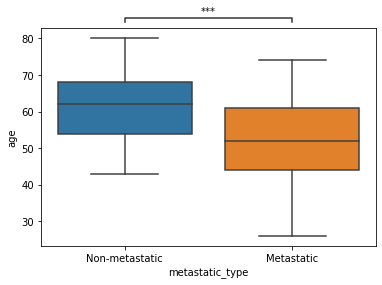

In [15]:
#the relationship between age and metastatic_type
foo = data1.explode('age')
foo['age'] = foo['age'].astype('float')
p4=sns.boxplot(data=foo,x="metastatic_type", y="age")
test_results = add_stat_annotation(p4,data=foo, x="metastatic_type", y="age",box_pairs=[("Non-metastatic", "Metastatic")],test='Mann-Whitney', text_format='star',loc='outside', verbose=2)
plt.savefig(save_path+"//"+"tmpd.pdf",dpi=400,facecolor='white',overwrite=True)

C:\Users\61416\AppData\Local\Temp\ipykernel_31324\998021593.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("D:\CCLE\pic"+"\\"+"tmp1.pdf",dpi=400,facecolor='white',overwrite=True)


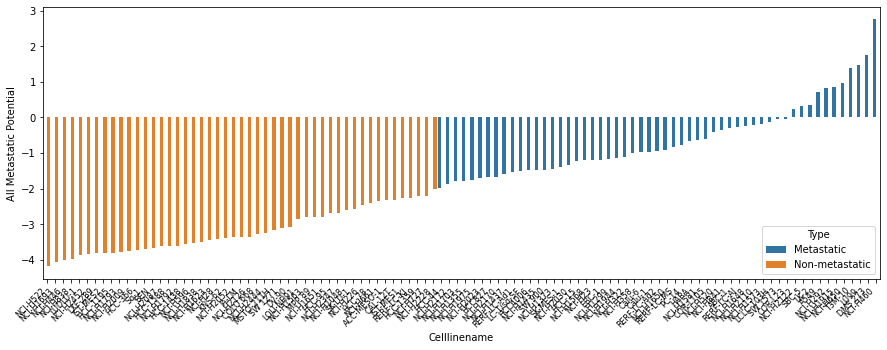

In [16]:
fig = plt.figure(figsize=(15, 5)) 
ax = fig.add_subplot(111)
bars =sns.barplot(x= 'Celllinename', y='all5',hue='metastatic_type',data=CCLE_metmap500MP_lung,order=CCLE_metmap500MP_lung.sort_values(by='all5')['Celllinename'] )
x_axis = bars.axes.get_xaxis()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45,fontsize=8)
ax.legend(title='Type')
plt.ylabel("All Metastatic Potential")
plt.savefig("D:\CCLE\pic"+"\\"+"tmp1.pdf",dpi=400,facecolor='white',overwrite=True)